In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import logging 
logging.basicConfig(level=logging.INFO)
from __future__ import annotations

import datetime as dt
import logging
from collections import namedtuple
from operator import itemgetter
from pathlib import Path
from typing import TYPE_CHECKING

import geopandas as gpd
import numpy as np
import pandas as pd
import xarray as xr
from dask import compute, delayed
from dask.array import absolute, arccos, cos, maximum, mod, radians, sin, sqrt, arcsin, arctan2, radians, arctan
from dask.diagnostics import ProgressBar
from numpy import pi
from scipy.sparse import csr_matrix
from atlite.aggregate import aggregate_matrix
from atlite.gis import spdiag
from numpy import pi
import sys
from numpy import logical_and

from atlite import csp as cspm

In [2]:
logger = logging.getLogger(__name__)

In [3]:
def SolarPosition(ds, time_shift="0H"):

    # up to h and dec from [1]

    time_shift = pd.to_timedelta(time_shift)
    #for the models: 
    t = ds.indexes["time"]#.to_datetimeindex()
    t = t + time_shift
    #for the era5
    #t=ds.indexes["time"] + time_shift
    n = xr.DataArray(t.to_julian_date(), coords=ds["time"].coords) - 2451545.0
    hour = (ds["time"] + time_shift).dt.hour
    minute = (ds["time"] + time_shift).dt.minute

    # Operations make new DataArray eager; reconvert to lazy dask arrays
    chunks = ds.chunksizes.get("time", "auto")
    if isinstance(chunks, tuple):
        chunks = chunks[0]
    n = n.chunk(chunks)
    hour = hour.chunk(chunks)
    minute = minute.chunk(chunks)

    L = 280.460 + 0.9856474 * n  # mean longitude (deg)
    g = radians(357.528 + 0.9856003 * n)  # mean anomaly (rad)
    l = radians(L + 1.915 * sin(g) + 0.020 * sin(2 * g))  # ecliptic long. (rad)
    ep = radians(23.439 - 4e-7 * n)  # obliquity of the ecliptic (rad)

    ra = arctan2(cos(ep) * sin(l), cos(l))  # right ascencion (rad)
    lmst = (6.697375 + (hour + minute / 60.0) + 0.0657098242 * n) * 15.0 + ds[
        "lon"
    ]  # local mean sidereal time (deg)
    h = (radians(lmst) - ra + pi) % (2 * pi) - pi  # hour angle (rad)

    dec = arcsin(sin(ep) * sin(l))  # declination (rad)

    # alt and az from [2]
    lat = radians(ds["lat"])
    # Clip before arcsin to prevent values < -1. from rounding errors; can
    # cause NaNs later
    alt = arcsin(
        (sin(dec) * sin(lat) + cos(dec) * cos(lat) * cos(h)).clip(min=-1.0, max=1.0)
    ).rename("altitude")
    alt.attrs["time shift"] = f"{time_shift}"
    alt.attrs["units"] = "rad"

    az = arccos(
        ((sin(dec) * cos(lat) - cos(dec) * sin(lat) * cos(h)) / cos(alt)).clip(
            min=-1.0, max=1.0
        )
    )
    az = az.where(h <= 0, 2 * pi - az).rename("azimuth")
    az.attrs["time shift"] = f"{time_shift}"
    az.attrs["units"] = "rad"

    vars = {da.name: da for da in [alt, az]}
    solar_position = xr.Dataset(vars)

    return solar_position

In [4]:
filepath_model="/groups/FutureWind/SFCRAD/CanESM5/historical/r1i1p2f1/rsds_rsdsdiff_tas_2014.nc"
ds_model_2014 = xr.open_dataset(filepath_model, decode_times=True)

In [5]:
# Ensure the time coordinate is in datetime64 format
ds_model_2014 = ds_model_2014.assign_coords(time=ds_model_2014.time.astype("datetime64[ns]"))

# Shift the time index backward by 1.5 hours to align with the start of the interval
ds_model_2014_shifted = ds_model_2014.assign_coords(
    time=ds_model_2014.time - np.timedelta64(90, "m")
)

# Resample to hourly intervals, forward-filling the 3-hourly values
ds_model_2014_h = ds_model_2014_shifted.resample(time="1H").ffill()

# Extend the time index to include the last hour of the year
new_time_index = pd.date_range(
    start=ds_model_2014_h.time.min().values,
    end="2014-12-31T23:00",
    freq="1H"
)

# Reindex the dataset and forward-fill missing values
ds_model_2014_h = ds_model_2014_h.reindex(time=new_time_index, method="ffill")

/home/s233224/anaconda3/envs/atlite_cmip6_2025/lib/python3.13/site-packages/xarray/groupers.py:487: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  self.index_grouper = pd.Grouper(
/tmp/ipykernel_88835/969227038.py:13: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  new_time_index = pd.date_range(


In [6]:
ds_model_2014_h

<xarray.Dataset> Size: 59MB
Dimensions:   (lon: 28, lat: 20, time: 8760)
Coordinates:
  * lon       (lon) float32 112B -28.12 -25.31 -22.5 -19.69 ... 42.19 45.0 47.81
  * lat       (lat) float32 80B 20.93 23.72 26.51 29.3 ... 68.37 71.16 73.95
  * time      (time) datetime64[ns] 70kB 2014-01-01 ... 2014-12-31T23:00:00
Data variables:
    rsds      (time, lat, lon) float32 20MB ...
    rsdsdiff  (time, lat, lon) float32 20MB ...
    tas       (time, lat, lon) float32 20MB ...
Attributes:
    data_source:    Processed data from CMIP6 runs
    experiment:     historical
    source:         CanESM5
    variant_label:  r1i1p2f1
    data_written:   12/03/2025 13:59

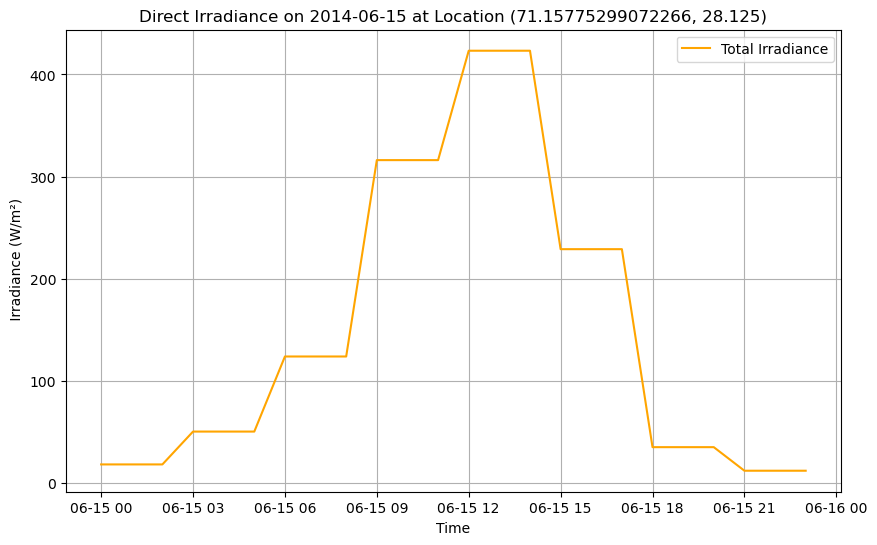

In [7]:
import matplotlib.pyplot as plt
# Select a random location (latitude and longitude)
random_lat = np.random.choice(ds_model_2014_h['lat'].values)
random_lon = np.random.choice(ds_model_2014_h['lon'].values)

# Select a specific day (e.g., 2014-06-15)
selected_day = "2014-06-15"
direct_irradiance = ds_model_2014_h['rsds'].sel(
    time=slice(f"{selected_day}T00:00", f"{selected_day}T23:59"),
    lat=random_lat,
    lon=random_lon
)

# Plot the direct irradiance values
plt.figure(figsize=(10, 6))
plt.plot(direct_irradiance['time'], direct_irradiance, label="Total Irradiance", color="orange")
plt.title(f"Direct Irradiance on {selected_day} at Location ({random_lat}, {random_lon})")
plt.xlabel("Time")
plt.ylabel(" Irradiance (W/m²)")
plt.grid()
plt.legend()
plt.show()

In [8]:
solar_position_model=SolarPosition(ds_model_2014_h, time_shift="+30min") #model data now needs a +30min time shift to take the solar position at the half hour
# the data is the average in a 1h interval, so the solar position is at the middle of the hour

In [9]:
solar_position_model['altitude']

<xarray.DataArray 'altitude' (time: 8760, lat: 20, lon: 28)> Size: 39MB
dask.array<arcsin, shape=(8760, 20, 28), dtype=float64, chunksize=(8760, 20, 28), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 70kB 2014-01-01 ... 2014-12-31T23:00:00
  * lat      (lat) float32 80B 20.93 23.72 26.51 29.3 ... 68.37 71.16 73.95
  * lon      (lon) float32 112B -28.12 -25.31 -22.5 -19.69 ... 42.19 45.0 47.81
Attributes:
    time shift:  0 days 00:30:00
    units:       rad

In [10]:
def get_orientation(name, **params):
    """
    Definitions:
    -`slope` is the angle between ground and panel.
    -`azimuth` is the clockwise angle from North.
        i.e. azimuth = 180 faces exactly South
    """
    if isinstance(name, dict):
        params = name
        name = params.pop("name", "constant")
    return getattr(sys.modules[__name__], f"make_{name}")(**params)


def make_latitude_optimal():
    """
    Returns an optimal tilt angle for the given ``lat``, assuming that the
    panel is facing towards the equator, using a simple method from [1].

    This method only works for latitudes between 0 and 50. For higher
    latitudes, a static 40 degree angle is returned.

    These results should be used with caution, but there is some
    evidence that tilt angle may not be that important [2].

    Function and documentation has been adapted from gsee [3].

    [1] http://www.solarpaneltilt.com/#fixed
    [2] http://dx.doi.org/10.1016/j.solener.2010.12.014
    [3] https://github.com/renewables-ninja/gsee/blob/master/gsee/pv.py

    Parameters
    ----------
    lat : float
        Latitude in degrees.

    """

    def latitude_optimal(lon, lat, solar_position):
        slope = np.empty_like(lat.values)

        below_25 = np.abs(lat.values) <= np.radians(25)
        below_50 = np.abs(lat.values) <= np.radians(50)

        slope[below_25] = 0.87 * np.abs(lat.values[below_25])
        slope[~below_25 & below_50] = 0.76 * np.abs(
            lat.values[~below_25 & below_50]
        ) + np.radians(0.31)
        slope[~below_50] = np.radians(40.0)

        # South orientation for panels on northern hemisphere and vice versa
        azimuth = np.where(lat.values < 0, 0, pi)
        return dict(
            slope=xr.DataArray(slope, coords=lat.coords),
            azimuth=xr.DataArray(azimuth, coords=lat.coords),
        )

    return latitude_optimal


def make_constant(slope, azimuth):
    slope = radians(slope)
    azimuth = radians(azimuth)

    def constant(lon, lat, solar_position):
        return dict(slope=slope, azimuth=azimuth)

    return constant


def make_latitude(azimuth=180):
    azimuth = radians(azimuth)

    def latitude(lon, lat, solar_position):
        return dict(slope=lat, azimuth=azimuth)

    return latitude


def SurfaceOrientation(ds, solar_position, orientation, tracking=None):
    """
    Compute cos(incidence) for slope and panel azimuth.

    References
    ----------
    [1] Sproul, A. B., Derivation of the solar geometric relationships using
    vector analysis, Renewable Energy, 32(7), 1187–1205 (2007).
    [2] Marion, William F., and Aron P. Dobos. Rotation angle for the optimum
    tracking of one-axis trackers. No. NREL/TP-6A20-58891. National Renewable
    Energy Lab.(NREL), Golden, CO (United States), 2013.

    """
    lon = radians(ds["lon"])
    lat = radians(ds["lat"])

    orientation = orientation(lon, lat, solar_position)
    surface_slope = orientation["slope"]
    surface_azimuth = orientation["azimuth"]

    sun_altitude = solar_position["altitude"]
    sun_azimuth = solar_position["azimuth"]

    if tracking is None:
        cosincidence = sin(surface_slope) * cos(sun_altitude) * cos(
            surface_azimuth - sun_azimuth
        ) + cos(surface_slope) * sin(sun_altitude)

    elif tracking == "horizontal":  # horizontal tracking with horizontal axis
        axis_azimuth = orientation[
            "azimuth"
        ]  # here orientation['azimuth'] refers to the azimuth of the tracker axis.
        rotation = arctan(
            (cos(sun_altitude) / sin(sun_altitude)) * sin(sun_azimuth - axis_azimuth)
        )
        surface_slope = abs(rotation)
        surface_azimuth = axis_azimuth + arcsin(
            sin(rotation / sin(surface_slope))
        )  # the 2nd part yields +/-1 and determines if the panel is facing east or west
        cosincidence = cos(surface_slope) * sin(sun_altitude) + sin(
            surface_slope
        ) * cos(sun_altitude) * cos(sun_azimuth - surface_azimuth)

    elif tracking == "tilted_horizontal":  # horizontal tracking with tilted axis'
        axis_tilt = orientation[
            "slope"
        ]  # here orientation['slope'] refers to the tilt of the tracker axis.

        rotation = arctan(
            (cos(sun_altitude) * sin(sun_azimuth - surface_azimuth))
            / (
                cos(sun_altitude) * cos(sun_azimuth - surface_azimuth) * sin(axis_tilt)
                + sin(sun_altitude) * cos(axis_tilt)
            )
        )

        surface_slope = arccos(cos(rotation) * cos(axis_tilt))

        azimuth_difference = sun_azimuth - surface_azimuth
        azimuth_difference = np.where(
            azimuth_difference > pi, 2 * pi - azimuth_difference, azimuth_difference
        )
        azimuth_difference = np.where(
            azimuth_difference < -pi, 2 * pi + azimuth_difference, azimuth_difference
        )
        rotation = np.where(
            logical_and(rotation < 0, azimuth_difference > 0),
            rotation + pi,
            rotation,
        )
        rotation = np.where(
            logical_and(rotation > 0, azimuth_difference < 0),
            rotation - pi,
            rotation,
        )

        cosincidence = cos(rotation) * (
            sin(axis_tilt) * cos(sun_altitude) * cos(sun_azimuth - surface_azimuth)
            + cos(axis_tilt) * sin(sun_altitude)
        ) + sin(rotation) * cos(sun_altitude) * sin(sun_azimuth - surface_azimuth)

    elif tracking == "vertical":  # vertical tracking, surface azimuth = sun_azimuth
        cosincidence = sin(surface_slope) * cos(sun_altitude) + cos(
            surface_slope
        ) * sin(sun_altitude)
    elif tracking == "dual":  # both vertical and horizontal tracking
        cosincidence = np.float64(1.0)
    else:
        assert False, (
            "Values describing tracking system must be None for no tracking,"
            + "'horizontal' for 1-axis horizontal tracking,"
            + "tilted_horizontal' for 1-axis horizontal tracking of tilted panle,"
            + "vertical' for 1-axis vertical tracking, or 'dual' for 2-axis tracking"
        )

    # fixup incidence angle: if the panel is badly oriented and the sun shines
    # on the back of the panel (incidence angle > 90degree), the irradiation
    # would be negative instead of 0; this is prevented here.
    cosincidence = cosincidence.clip(min=0)

    return xr.Dataset(
        {
            "cosincidence": cosincidence,
            "slope": surface_slope,
            "azimuth": surface_azimuth,
        }
    )

In [11]:
orientation='latitude_optimal'

In [12]:
orientation = get_orientation(orientation)

In [13]:
surface_orientation_model=SurfaceOrientation(ds_model_2014, solar_position_model, orientation, tracking=None)

In [14]:
surface_orientation_model

<xarray.Dataset> Size: 39MB
Dimensions:       (lat: 20, time: 8760, lon: 28)
Coordinates:
  * lat           (lat) float32 80B 20.93 23.72 26.51 29.3 ... 68.37 71.16 73.95
  * time          (time) datetime64[ns] 70kB 2014-01-01 ... 2014-12-31T23:00:00
  * lon           (lon) float32 112B -28.12 -25.31 -22.5 ... 42.19 45.0 47.81
Data variables:
    cosincidence  (lat, time, lon) float64 39MB dask.array<chunksize=(20, 8760, 28), meta=np.ndarray>
    slope         (lat) float32 80B 0.3178 0.3602 0.3571 ... 0.6981 0.6981
    azimuth       (lat) float64 160B 3.142 3.142 3.142 ... 3.142 3.142 3.142

In [15]:
trigon_model='simple'
clearsky_model='simple'
tracking=None

In [16]:
from regridding_functions import read_and_average_era5_marta
mean_albedo_Era5=read_and_average_era5_marta('albedo')

/home/s233224/anaconda3/envs/atlite_cmip6_2025/lib/python3.13/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(


['/groups/EXTREMES/cutouts/europe-1980-era5.nc', '/groups/EXTREMES/cutouts/europe-1981-era5.nc', '/groups/EXTREMES/cutouts/europe-1982-era5.nc', '/groups/EXTREMES/cutouts/europe-1983-era5.nc', '/groups/EXTREMES/cutouts/europe-1984-era5.nc', '/groups/EXTREMES/cutouts/europe-1985-era5.nc', '/groups/EXTREMES/cutouts/europe-1986-era5.nc', '/groups/EXTREMES/cutouts/europe-1987-era5.nc', '/groups/EXTREMES/cutouts/europe-1988-era5.nc', '/groups/EXTREMES/cutouts/europe-1989-era5.nc', '/groups/EXTREMES/cutouts/europe-1990-era5.nc', '/groups/EXTREMES/cutouts/europe-1991-era5.nc', '/groups/EXTREMES/cutouts/europe-1992-era5.nc', '/groups/EXTREMES/cutouts/europe-1993-era5.nc', '/groups/EXTREMES/cutouts/europe-1994-era5.nc', '/groups/EXTREMES/cutouts/europe-1995-era5.nc', '/groups/EXTREMES/cutouts/europe-1996-era5.nc', '/groups/EXTREMES/cutouts/europe-1997-era5.nc', '/groups/EXTREMES/cutouts/europe-1998-era5.nc', '/groups/EXTREMES/cutouts/europe-1999-era5.nc', '/groups/EXTREMES/cutouts/europe-2000-e

In [17]:
from regridding_functions import regrid
regridder_era5_model=regrid(mean_albedo_Era5, ds_model_2014, method='conservative')
mean_albedo_model=regridder_era5_model(mean_albedo_Era5) #regrid the mean albedo to the model grid


189 190
157 158
28 29
20 21


/home/s233224/anaconda3/envs/atlite_cmip6_2025/lib/python3.13/site-packages/xesmf/frontend.py:718: UserWarning: Using dimensions ('y', 'x') from data variable albedo as the horizontal dimensions for the regridding.
  warnings.warn(


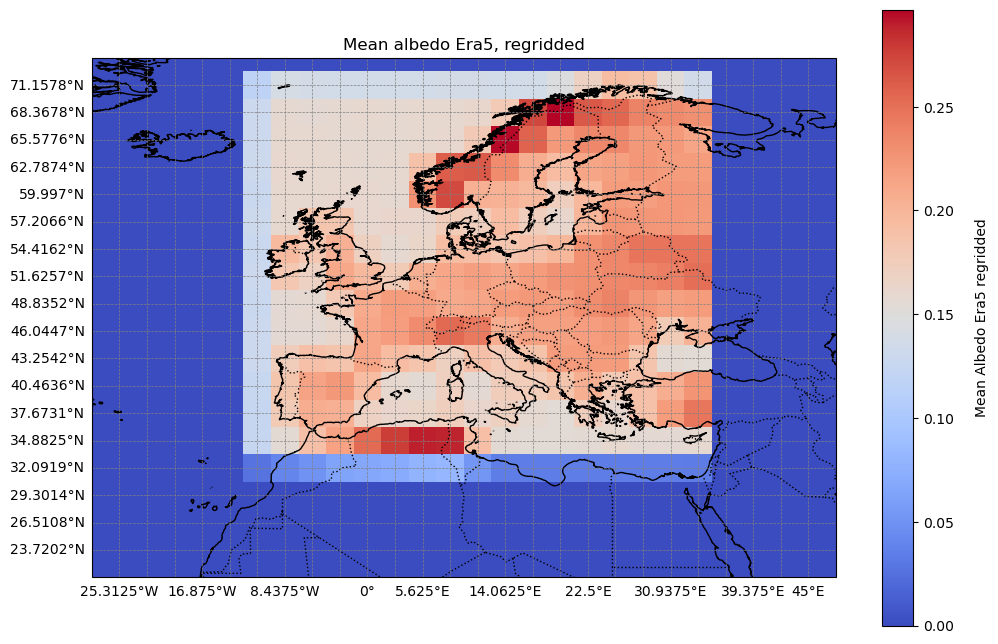

In [15]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Ensure these variables are defined before running the code
lon = mean_albedo_model.lon  # List or array of longitude ticks for gridlines
lat = mean_albedo_model.lat  # List or array of latitude ticks for gridlines

# Create the plot
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([lon.min(), lon.max(), lat.min(), lat.max()], crs=ccrs.PlateCarree())

# Plot the bias factor (masked)
c = ax.pcolormesh(
    lon, lat, mean_albedo_model,  # Ensure correct shapes
    transform=ccrs.PlateCarree(),
    cmap='coolwarm',  # Colormap for bias factor
    shading='auto',  # Clip extreme outliers
)

# Add map features
ax.coastlines(resolution='10m', linewidth=1)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='white')
ax.set_title("Mean albedo Era5, regridded")

# Add gridlines
gridlines = ax.gridlines(
    draw_labels=True, 
    linewidth=0.5, 
    color='gray', 
    linestyle='--', 
    xlocs=lon,  # Replace with actual longitude ticks
    ylocs=lat,  # Replace with actual latitude ticks
    x_inline=False, 
    y_inline=False
)
gridlines.top_labels = False  # Disable labels on the top
gridlines.right_labels = False  # Disable labels on the right

# Add colorbar
cbar = fig.colorbar(c, ax=ax, orientation='vertical')
cbar.set_label('Mean Albedo Era5 regridded', rotation=90, labelpad=15)

plt.show()

In [20]:
mean_albedo_model

<xarray.DataArray (lat: 20, lon: 28)> Size: 2kB
dask.array<astype, shape=(20, 28), dtype=float32, chunksize=(20, 28), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 80B 20.93 23.72 26.51 29.3 ... 68.37 71.16 73.95
  * lon      (lon) float32 112B -28.12 -25.31 -22.5 -19.69 ... 42.19 45.0 47.81
Attributes:
    regrid_method:  conservative

In [18]:
# SPDX-FileCopyrightText: Contributors to atlite <https://github.com/pypsa/atlite>
#
# SPDX-License-Identifier: MIT

import logging

import numpy as np
from dask.array import cos, fmax, fmin, radians, sin, sqrt

logger = logging.getLogger(__name__)


def DiffuseHorizontalIrrad(ds, solar_position, clearsky_model, influx):
    # Clearsky model from Reindl 1990 to split downward radiation into direct
    # and diffuse contributions. Should switch to more up-to-date model, f.ex.
    # Ridley et al. (2010) http://dx.doi.org/10.1016/j.renene.2009.07.018 ,
    # Lauret et al. (2013):http://dx.doi.org/10.1016/j.renene.2012.01.049

    sinaltitude = sin(solar_position["altitude"])
    influx_toa = ds["influx_toa"]

    if clearsky_model is None:
        clearsky_model = (
            "enhanced" if "temperature" in ds and "humidity" in ds else "simple"
        )

    # Reindl 1990 clearsky model

    k = influx / influx_toa  # clearsky index
    # k.values[k.values > 1.0] = 1.0
    # k = k.rename('clearsky index')

    if clearsky_model == "simple":
        # Simple Reindl model without ambient air temperature and
        # relative humidity
        fraction = (
            ((k > 0.0) & (k <= 0.3))
            * fmin(1.0, 1.020 - 0.254 * k + 0.0123 * sinaltitude)
            + ((k > 0.3) & (k < 0.78))
            * fmin(0.97, fmax(0.1, 1.400 - 1.749 * k + 0.177 * sinaltitude))
            + (k >= 0.78) * fmax(0.1, 0.486 * k - 0.182 * sinaltitude)
        )
    elif clearsky_model == "enhanced":
        # Enhanced Reindl model with ambient air temperature and relative
        # humidity
        T = ds["tas"]
        rh = ds["humidity"]

        fraction = (
            ((k > 0.0) & (k <= 0.3))
            * fmin(
                1.0,
                1.000 - 0.232 * k + 0.0239 * sinaltitude - 0.000682 * T + 0.0195 * rh,
            )
            + ((k > 0.3) & (k < 0.78))
            * fmin(
                0.97,
                fmax(
                    0.1,
                    1.329 - 1.716 * k + 0.267 * sinaltitude - 0.00357 * T + 0.106 * rh,
                ),
            )
            + (k >= 0.78)
            * fmax(0.1, 0.426 * k - 0.256 * sinaltitude + 0.00349 * T + 0.0734 * rh)
        )
    else:
        raise KeyError("`clearsky model` must be chosen from 'simple' and 'enhanced'")

    # Set diffuse fraction to one when the sun isn't up
    # fraction = fraction.where(sinaltitude >= sin(radians(threshold))).fillna(1.0)
    # fraction = fraction.rename('fraction index')

    return (influx * fraction).rename("diffuse horizontal")


def TiltedDiffuseIrrad(ds, solar_position, surface_orientation, direct, diffuse):
    # Hay-Davies Model

    sinaltitude = sin(solar_position["altitude"])
    influx_toa = ds["influx_toa"]

    cosincidence = surface_orientation["cosincidence"]
    surface_slope = surface_orientation["slope"]

    influx = direct + diffuse

    with np.errstate(divide="ignore", invalid="ignore"):
        # brightening factor
        f = sqrt(direct / influx).fillna(0.0)

        # anisotropy factor
        A = direct / influx_toa

    # geometric factor
    R_b = cosincidence / sinaltitude

    diffuse_t = (
        (1.0 - A)
        * ((1 + cos(surface_slope)) / 2.0)
        * (1.0 + f * sin(surface_slope / 2.0) ** 3)
        + A * R_b
    ) * diffuse

    # fixup: clip all negative values (unclear why it gets negative)
    # note: REatlas does not do the fixup
    if logger.isEnabledFor(logging.WARNING):
        if ((diffuse_t < 0.0) & (sinaltitude > sin(radians(1.0)))).any():
            logger.warning(
                "diffuse_t exhibits negative values above altitude threshold."
            )

    with np.errstate(invalid="ignore"):
        diffuse_t = diffuse_t.clip(min=0).fillna(0)

    return diffuse_t.rename("diffuse tilted")


def TiltedDirectIrrad(solar_position, surface_orientation, direct):
    sinaltitude = sin(solar_position["altitude"])
    cosincidence = surface_orientation["cosincidence"]

    # geometric factor
    R_b = cosincidence / sinaltitude

    return (R_b * direct).rename("direct tilted")


def _albedo(mean_albedo):

    if mean_albedo is not None:
        albedo = mean_albedo
    else:
        raise ValueError("An external albedo DataArray must be provided.")

    return albedo


def TiltedGroundIrrad(ds, solar_position, surface_orientation, influx, mean_albedo):
    surface_slope = surface_orientation["slope"]
    ground_t = influx * _albedo(mean_albedo) * (1.0 - cos(surface_slope)) / 2.0
    return ground_t.rename("ground tilted")


def TiltedIrradiation(
    ds,
    mean_albedo,
    solar_position,
    surface_orientation,
    trigon_model,
    clearsky_model,
    tracking=0,
    altitude_threshold=1.0,
    irradiation="total",
):
    """
    Calculate the irradiation on a tilted surface.

    Parameters
    ----------
    ds : xarray.Dataset
        Cutout data used for calculating the irradiation on a tilted surface.
    solar_position : xarray.Dataset
        Solar position calculated using atlite.pv.SolarPosition,
        containing a solar 'altitude' (in rad, 0 to pi/2) for the 'ds' dataset.
    surface_orientation : xarray.Dataset
        Surface orientation calculated using atlite.orientation.SurfaceOrientation.
    trigon_model : str
        Type of trigonometry model. Defaults to 'simple'if used via `convert_irradiation`.
    clearsky_model : str or None
        Either the 'simple' or the 'enhanced' Reindl clearsky
        model. The default choice of None will choose dependending on
        data availability, since the 'enhanced' model also
        incorporates ambient air temperature and relative humidity.
        NOTE: this option is only used if the used climate dataset
        doesn't provide direct and diffuse irradiation separately!
    altitude_threshold : float
        Threshold for solar altitude in degrees. Values in range (0, altitude_threshold]
        will be set to zero. Default value equals 1.0 degrees.
    irradiation : str
        The irradiation quantity to be returned. Defaults to "total" for total
        combined irradiation. Other options include "direct" for direct irradiation,
        "diffuse" for diffuse irradation, and "ground" for irradiation reflected
        by the ground via albedo. NOTE: "ground" irradiation is not calculated
        by all `trigon_model` options in the `convert_irradiation` method,
        so use with caution!

    Returns
    -------
    result : xarray.DataArray
        The desired irradiation quantity on the tilted surface.

    """
    influx_toa = ds["rsds"] #definin influx_toa as rsds from model. 

    def clip(influx, influx_max):
        # use .data in clip due to dask-xarray incompatibilities
        return influx.clip(min=0, max=influx_max.transpose(*influx.dims).data)

    #if "influx" in ds:
    #    influx = clip(ds["influx"], influx_toa)
    #    diffuse = DiffuseHorizontalIrrad(ds, solar_position, clearsky_model, influx)
    #    direct = influx - diffuse
    if "rsds" in ds and "rsdsdiff" in ds:
        direct = clip((ds["rsds"]-ds['rsdsdiff']), influx_toa)
        diffuse = clip(ds["rsdsdiff"], (influx_toa - direct))
    else:
        raise AssertionError(
            "Need either influx or influx_direct and influx_diffuse in the "
            "dataset. Check your cutout and dataset module."
        )
    if trigon_model == "simple": #function only modified to use the simple model
        k = surface_orientation["cosincidence"] / sin(solar_position["altitude"])
        if tracking != "dual":
            cos_surface_slope = cos(surface_orientation["slope"])
        elif tracking == "dual":
            cos_surface_slope = sin(solar_position["altitude"])

        influx = direct + diffuse
        direct_t = k * direct
        diffuse_t = (1.0 + cos_surface_slope) / 2.0 * diffuse
        ground_t = _albedo(mean_albedo) * influx * ((1.0 - cos_surface_slope) / 2.0)

        total_t = direct_t.fillna(0.0) + diffuse_t.fillna(0.0) + ground_t.fillna(0.0)
    else:
        diffuse_t = TiltedDiffuseIrrad(
            ds, solar_position, surface_orientation, direct, diffuse
        )
        direct_t = TiltedDirectIrrad(solar_position, surface_orientation, direct)
        ground_t = TiltedGroundIrrad(
            ds, solar_position, surface_orientation, direct + diffuse
        )

        total_t = direct_t + diffuse_t + ground_t

    if irradiation == "total":
        result = total_t.rename("total tilted")
    elif irradiation == "direct":
        result = direct_t.rename("direct tilted")
    elif irradiation == "diffuse":
        result = diffuse_t.rename("diffuse tilted")
    elif irradiation == "ground":
        result = ground_t.rename("ground tilted")

    # The solar_position algorithms have a high error for small solar altitude
    # values, leading to big overall errors from the 1/sinaltitude factor.
    # => Suppress irradiation below solar altitudes of 1 deg.

    cap_alt = solar_position["altitude"] < radians(altitude_threshold)
    result = result.where(~(cap_alt | (direct + diffuse <= 0.01)), 0)
    result.attrs["units"] = "W m**-2"

    return result

In [19]:
irradiation_model=TiltedIrradiation(
    ds_model_2014_h,
    mean_albedo_model,
    solar_position_model,
    surface_orientation_model,
    trigon_model,
    clearsky_model,
    tracking=0,
    altitude_threshold=1.0,
    irradiation="total",
)

In [115]:
irradiation_model

<xarray.DataArray 'total tilted' (lat: 20, time: 8760, lon: 28)> Size: 39MB
dask.array<where, shape=(20, 8760, 28), dtype=float64, chunksize=(20, 8760, 28), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 80B 20.93 23.72 26.51 29.3 ... 68.37 71.16 73.95
  * time     (time) datetime64[ns] 70kB 2014-01-01 ... 2014-12-31T23:00:00
  * lon      (lon) float32 112B -28.12 -25.31 -22.5 -19.69 ... 42.19 45.0 47.81
Attributes:
    units:    W m**-2

In [71]:
import numpy as np

# Count the total number of values
total_values = np.size(irradiation_model.values)

# Count the number of zero values
zero_values = np.sum(irradiation_model.values == 0)

# Print the results
print(f"Total values: {total_values}")
print(f"Number of zero values: {zero_values}")
print(f"Percentage of zero values: {100 * zero_values / total_values:.2f}%")

Total values: 4904480
Number of zero values: 2514054
Percentage of zero values: 51.26%


In [32]:
# SPDX-FileCopyrightText: Contributors to atlite <https://github.com/pypsa/atlite>
#
# SPDX-License-Identifier: MIT

import numpy as np

# Huld model was copied from gsee -- global solar energy estimator
# by Stefan Pfenninger
# https://github.com/renewables-ninja/gsee/blob/master/gsee/pv.py


def _power_huld(irradiance, t_amb, pc):
    """
    AC power per capacity predicted by Huld model, based on W/m2 irradiance.

    Maximum power point tracking is assumed.

    [1] Huld, T. et al., 2010. Mapping the performance of PV modules,
    effects of module type and data averaging. Solar Energy, 84(2),
    p.324-338. DOI: 10.1016/j.solener.2009.12.002
    """
    # normalized module temperature
    T_ = (pc["c_temp_amb"] * t_amb + pc["c_temp_irrad"] * irradiance) - pc["r_tmod"]

    # normalized irradiance
    G_ = irradiance / pc["r_irradiance"]

    log_G_ = np.log(G_.where(G_ > 0))
    # NB: np.log without base implies base e or ln
    eff = (
        1
        + pc["k_1"] * log_G_
        + pc["k_2"] * (log_G_) ** 2
        + T_ * (pc["k_3"] + pc["k_4"] * log_G_ + pc["k_5"] * log_G_**2)
        + pc["k_6"] * (T_**2)
    )

    eff = eff.fillna(0.0).clip(min=0)

    da = G_ * eff * pc.get("inverter_efficiency", 1.0)
    da.attrs["units"] = "kWh/kWp"
    da = da.rename("specific generation")

    return da


def _power_bofinger(irradiance, t_amb, pc):
    """
    AC power per capacity predicted by bofinger model, based on W/m2
    irradiance.

    Maximum power point tracking is assumed.

    [2] Hans Beyer, Gerd Heilscher and Stefan Bofinger, 2004. A robust
    model for the MPP performance of different types of PV-modules
    applied for the performance check of grid connected systems.
    """
    fraction = (pc["NOCT"] - pc["Tamb"]) / pc["Intc"]

    eta_ref = (
        pc["A"]
        + pc["B"] * irradiance
        + pc["C"] * np.log(irradiance.where(irradiance != 0))
    )
    eta = (
        eta_ref
        * (1.0 + pc["D"] * (fraction * irradiance + (t_amb - pc["Tstd"])))
        / (1.0 + pc["D"] * fraction / pc["ta"] * eta_ref * irradiance)
    ).fillna(0)

    capacity = (pc["A"] + pc["B"] * 1000.0 + pc["C"] * np.log(1000.0)) * 1e3
    power = irradiance * eta * (pc.get("inverter_efficiency", 1.0) / capacity)
    power = power.where(irradiance >= pc["threshold"], 0)
    return power.rename("AC power")


def SolarPanelModel(ds, irradiance, pc):
    model = pc.get("model", "huld")

    if model == "huld":
        return _power_huld(irradiance, ds["tas"], pc)
    elif model == "bofinger":
        return _power_bofinger(irradiance, ds["tas"], pc)
    else:
        AssertionError(f"Unknown panel model: {model}")

In [33]:
panel = {
    "model": "huld",  # Model type
    "name": "CSi",  # Panel name
    "source": "Huld 2010",  # Source of the model

    # Used for calculating capacity per m2
    "efficiency": 0.1,  # Efficiency of the panel

    # Panel temperature coefficients
    "c_temp_amb": 1,  # Panel temperature coefficient of ambient temperature
    "c_temp_irrad": 0.035,  # Panel temperature coefficient of irradiance (K / (W/m2))

    # Reference conditions
    "r_tamb": 293,  # Reference ambient temperature (20 degC in Kelvin)
    "r_tmod": 298,  # Reference module temperature (25 degC in Kelvin)
    "r_irradiance": 1000,  # Reference irradiance (W/m^2)

    # Fitting parameters
    "k_1": -0.017162,
    "k_2": -0.040289,
    "k_3": -0.004681,
    "k_4": 0.000148,
    "k_5": 0.000169,
    "k_6": 0.000005,

    # Inverter efficiency
    "inverter_efficiency": 0.9
}

In [116]:
solar_panel = SolarPanelModel(ds_model_2014_h,irradiation_model, panel)

In [117]:
solar_panel

<xarray.DataArray 'specific generation' (lat: 20, time: 8760, lon: 28)> Size: 39MB
dask.array<mul, shape=(20, 8760, 28), dtype=float64, chunksize=(20, 8760, 28), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 80B 20.93 23.72 26.51 29.3 ... 68.37 71.16 73.95
  * time     (time) datetime64[ns] 70kB 2014-01-01 ... 2014-12-31T23:00:00
  * lon      (lon) float32 112B -28.12 -25.31 -22.5 -19.69 ... 42.19 45.0 47.81
Attributes:
    units:    kWh/kWp

In [118]:
aggregated_generation=solar_panel.sum(dim="time")

In [119]:
aggregated_generation

<xarray.DataArray 'specific generation' (lat: 20, lon: 28)> Size: 4kB
dask.array<sum-aggregate, shape=(20, 28), dtype=float64, chunksize=(20, 28), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 80B 20.93 23.72 26.51 29.3 ... 68.37 71.16 73.95
  * lon      (lon) float32 112B -28.12 -25.31 -22.5 -19.69 ... 42.19 45.0 47.81

In [120]:
aggregated_generation.sel(lat=33, lon=-12, method="nearest").values

array(1773.07662756)

In [121]:
aggregated_generation.values

array([[1617.02591523, 1650.44557929, 1752.87594241, 1783.75153666,
        1883.99110386, 1829.42906467, 1864.93104514, 1914.16105854,
        1965.3024264 , 1946.98427858, 1939.09241215, 1939.56374985,
        2017.70050426, 1998.89352757, 1979.52718386, 1953.90549635,
        1940.90674805, 1947.06922816, 1974.76849096, 1994.64553232,
        1982.40358097, 1948.56323258, 1910.70773065, 1908.65632937,
        1930.6729038 , 1883.39857039, 1926.80011517, 1884.38825889],
       [1576.5838635 , 1613.71400233, 1653.22994615, 1622.97711082,
        1863.83820943, 1891.14319713, 1883.08762738, 1900.06180121,
        1888.14687542, 1911.30742659, 1931.72859414, 1944.27034365,
        1960.80794797, 1965.21587375, 1944.90321729, 1972.34348424,
        1981.06345663, 1935.5402761 , 1954.30948703, 1977.85179614,
        1985.76096664, 1956.51239114, 1913.28693008, 1956.45463869,
        1933.5084859 , 1925.07009434, 1918.08125322, 1853.16379178],
       [1525.91953638, 1536.31355609, 1529.743